In [1]:
import tifffile
import pandas
import os 
import numpy as np
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from griottes import get_cell_properties, generate_contact_graph, generate_delaunay_graph, generate_geometric_graph, plot_3D
from griottes.graphmaker import graph_generation_func

import urllib3
import shutil

# I. Description

This notebook enables the user to reproduce the panels from figure 3 of ["Griottes: a generalist tool for network generation from segmented tissue images"](https://www.biorxiv.org/content/10.1101/2022.01.14.476345v1). The first part of the document shows how to generate a graph object from a 3D segmented image using the Delaunay-based network construction method. 

The second part of the notebook contains the code corresponding to the more advanced analysis shown in the paper. The data are available on the github release and will be directly downloaded to the local repository.

## 1. Load image and mask of nuclei

First download the image from the latest release of `Griottes` from the GitHub release and load the image to the notebook.

In [2]:
url = 'https://github.com/BaroudLab/Griottes/releases/download/v1.0-alpha/3D_spheroid_multichannel_image.tif'
filename = '3D_spheroid_multichannel_image.tif'

if not os.path.exists(filename):
    c = urllib3.PoolManager()

    with c.request('GET',url, preload_content=False) as resp, open(filename, 'wb') as out_file:
        shutil.copyfileobj(resp, out_file)

    resp.release_conn()
else:
    print('dataset already exists')

dataset already exists


In [3]:
spheroid_image = tifffile.imread('3D_spheroid_multichannel_image.tif')

## 2. Extracting single-cell fluorescence data
 
This is done by setting `analyze_fluo_channels` to `True`. Then multiple methods exist to measure the fluorescence proper. They are tuned by modifying `fluo_channel_analysis_method` option to `basic`, `local_voronoi` or `local_sphere`.

 - `basic` measures the fluorescence inside the cell mask. This method relies on the `skimage.regionprops` and is the quickest of the three.

 - `local_voronoi` generates a Voronoi tesselation of the tissue and measures the fluorescence inside the cell voxel.

 - `local_sphere` measures the fluorescence within a sphere of radius `radius` around the cell center.

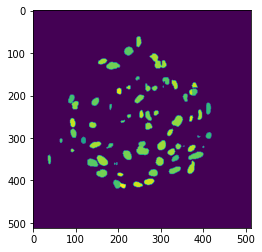

In [4]:
plt.imshow(spheroid_image[3, 250, ...])

In [5]:
single_cell_properties = get_cell_properties(
    spheroid_image,
    mask_channel = 3,
    analyze_fluo_channels = True,
    fluo_channel_analysis_method = 'basic',
    percentile = 10
    )

## 3. Network representation of tissues in 3D

From the extracted positions of the cell centers, it is possible to generate a network representation of the 3D spheroid. We have extracted the positions and properties of multiple spheroids that are available by executing the cells immediately below. These MSC spheroids have been incubated for 29 hours before being imaged and we detect cell type by comparing the intensity of the staining.

For illustration purposes we decide to attribute different cell types depending on the fluorescence measured within the mask. Any cell which `mean_intensity_1` is above the median is considered CD146+, otherwise it is CD146-.

In [6]:
url = 'https://github.com/BaroudLab/Griottes/releases/download/v1.0-alpha/single_spheroid_data.csv'
filename = 'single_spheroid_data.csv'

if not os.path.exists(filename):
    c = urllib3.PoolManager()

    with c.request('GET',url, preload_content=False) as resp, open(filename, 'wb') as out_file:
        shutil.copyfileobj(resp, out_file)

    resp.release_conn()
else:
    print('dataset already exists')
    
single_spheroid_data = pandas.read_csv('single_spheroid_data.csv')

dataset already exists


In [7]:
single_spheroid_data['cell_type'] = (single_spheroid_data.mean_intensity_1 > single_spheroid_data.mean_intensity_1.median()).astype(int)
single_spheroid_data.index = np.arange(len(single_spheroid_data))

legend_list = ['CD146-', 'CD146+']
single_spheroid_data['legend'] = [legend_list[single_spheroid_data.loc[i, 'cell_type']] for i in range(len(single_spheroid_data))]

color_list = [plt.cm.Set3(i) for i in range(2)]
single_spheroid_data['color'] = [color_list[single_spheroid_data.loc[i, 'cell_type']] for i in range(len(single_spheroid_data))]


To represent the spheroid from point-data we use the Delaunay-rule to build the spheroid. Instead of entering an image as an input the user can enter a pnadas DatFrame containing the columns listed in `descriptors`.

In [8]:
descriptors = ['x', 'y', 'legend', 'color', 'cell_type']

G_delaunay = generate_delaunay_graph(single_spheroid_data, 
                            descriptors = descriptors, 
                            distance = 70,
                            image_is_2D = False)

From the graph G it is possible to plot a visual representation of the network. Griottes contains several specific plotting functions adapted for the network representation of tisssues. These functions are called through the graph_plot module. Here we call a specific function for 3D plots.

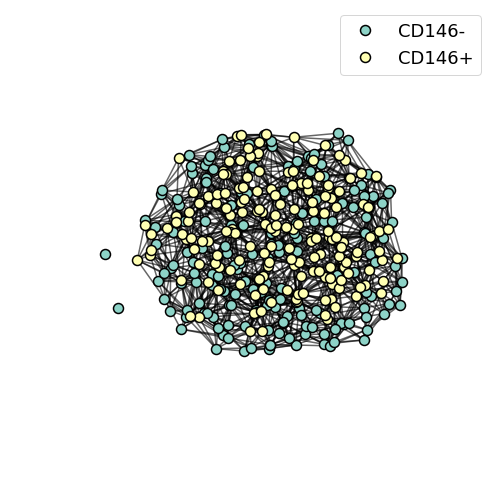

In [9]:
plot_3D(G_delaunay, 
        figsize = (7, 7),
        alpha_line=0.6,
        scatterpoint_size=10,
        legend=True,
        legend_fontsize = 18,
        theta = -0,
        psi = -0,
        xlim = (single_spheroid_data.x.min() - 5, single_spheroid_data.x.max() + 5),
        ylim = (single_spheroid_data.y.min() - 5, single_spheroid_data.y.max() + 5),
        zlim = (single_spheroid_data.z.min() - 5, single_spheroid_data.z.max() + 5))

# II. Spatial analysis of MSC spheroids

## 1. Attributing layers to spheroids

For analysing spheroids, it can be useful to have access to the cell properties as a function of their position within the spheroid. Each cell can be attributed a layer corresponding to the number of links connects each cell to a cell on the outside of the spheroid.

In [10]:
G_delaunay = graph_generation_func.attribute_layer(G_delaunay)

# attribute a layer to each node
layer_dict = nx.get_node_attributes(G_delaunay, 'layer')

for ind in single_spheroid_data.index:
    single_spheroid_data.loc[ind, 'layer'] = int(layer_dict[ind])

# enter the layer into the data table
for ind in single_spheroid_data.index:
    
    if single_spheroid_data.loc[ind, 'layer'] < 2:
        
        single_spheroid_data.loc[ind, 'color'] = 'tab:red'
        single_spheroid_data.loc[ind, 'legend'] = 'Outer layer'
        
    else:
        
        single_spheroid_data.loc[ind, 'color'] = 'tab:blue'
        single_spheroid_data.loc[ind, 'legend'] = 'Inner layers'

# generate a new graph including the layer information
descriptors = ['x', 'y', 'legend', 'color', 'cell_type']

G_layers = generate_delaunay_graph(single_spheroid_data, 
                                   descriptors = descriptors, 
                                   distance = 100)

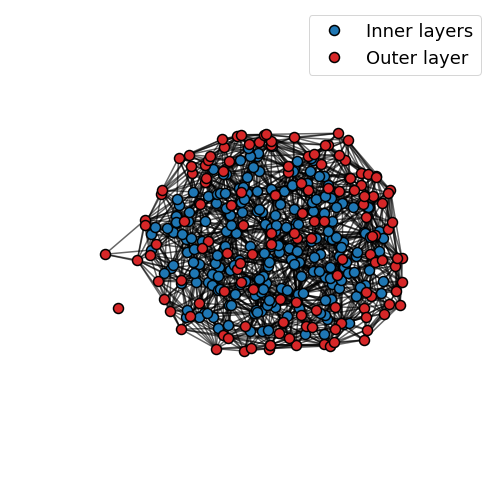

In [11]:
plot_3D(G_layers, 
        figsize = (7, 7),
        alpha_line=0.6,
        scatterpoint_size=10,
        legend=True,
        legend_fontsize = 18,
        theta = -0,
        psi = -0,
        xlim = (single_spheroid_data.x.min() - 5, single_spheroid_data.x.max() + 5),
        ylim = (single_spheroid_data.y.min() - 5, single_spheroid_data.y.max() + 5),
        zlim = (single_spheroid_data.z.min() - 5, single_spheroid_data.z.max() + 5))

## 2. Comparing graph properties between spheroids

We download single-cell data from multiple MSC spheroids that have incubated for 29 hours. This will allow us to look at spheroid to spheroid variability within the experiment.

In [12]:
url = 'https://github.com/BaroudLab/Griottes/releases/download/v1.0-alpha/multiple_spheroid_data_t29.csv'
filename = 'multiple_spheroid_data_t29.csv'

if not os.path.exists(filename):
    c = urllib3.PoolManager()

    with c.request('GET',url, preload_content=False) as resp, open(filename, 'wb') as out_file:
        shutil.copyfileobj(resp, out_file)

    resp.release_conn()
else:
    print('dataset already exists')
    
multiple_spheroid_data = pandas.read_csv('multiple_spheroid_data_t29.csv')

dataset already exists


In [13]:
def make_graphs(dataframe,
                descriptors,
                distance = 70):
    
    graph_list = []
    
    for spheroid_number in dataframe.spheroid_number.unique():
        
        loc_frame = dataframe[dataframe.spheroid_number == spheroid_number]
        
        G = generate_delaunay_graph(loc_frame, 
                                    descriptors = descriptors, 
                                    distance = distance)

        G = graph_generation_func.attribute_layer(G)

        layer_dict = nx.get_node_attributes(G, 'layer')
        
        graph_list.append(G)
    
    return graph_list

def get_neighbour_properties(G,
                             neighbour_descriptor):
    
    """
    
    This function iterates through the cells composing the spheroid
    and records the distribution of features with regard to each other
    in the tissue.
    
    """

    resultframe = pandas.DataFrame()
    i = 0
        
    neighbour_descriptors = nx.get_node_attributes(G, neighbour_descriptor)

    for node in G.nodes:
        
        resultframe.loc[i, 'label'] = node
        resultframe.loc[i, neighbour_descriptor] = neighbour_descriptors[node]
        resultframe.loc[i, 'degree'] = len([n for n in G.neighbors(node)])
        
        neighbour_props = [neighbour_descriptors[n] for n in G.neighbors(node)]
        neighbour_props_counter = Counter(neighbour_props)
                
        for key in neighbour_props_counter.keys():
            resultframe.loc[i, key] = neighbour_props_counter[key]
            
        i += 1

    return resultframe.fillna(0)


Here we choose to compare the degree distribution between spheroids.

In [14]:
descriptors = ['mean_intensity_1', 'color', 'legend']

legend_list = ['CD146-', 'CD146+']
multiple_spheroid_data['legend'] = [legend_list[multiple_spheroid_data.loc[i, 'color_int']] for i in range(len(multiple_spheroid_data))]

color_list = [plt.cm.Set2(i) for i in range(2)]
multiple_spheroid_data['color'] = [color_list[multiple_spheroid_data.loc[i, 'color_int']] for i in range(len(multiple_spheroid_data))]
multiple_spheroid_data['cell_type'] = multiple_spheroid_data['color_int']

graph_list = make_graphs(multiple_spheroid_data,
                         descriptors, 
                         distance = 70)

In [15]:
all_graph_neighbourhood_props = pandas.DataFrame()

for graph in graph_list:
        
    loc_neighbourhood_props = get_neighbour_properties(graph,
                             neighbour_descriptor = 'legend')
    all_graph_neighbourhood_props = all_graph_neighbourhood_props.append(loc_neighbourhood_props)

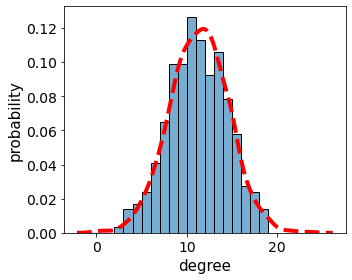

In [16]:
fig, ax = plt.subplots(figsize = (5,4))

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

g = sns.histplot(loc_neighbourhood_props, 
             x="degree",
             stat = 'probability',
             palette='Set2',
             kde = False,
             cumulative=False,
             common_norm=False,
             binwidth = 1,
             alpha = 0.6)

sns.kdeplot(data=all_graph_neighbourhood_props, 
            x="degree",
            c = 'r',
            ls = '--',
            lw = 4)

ax.set_ylabel('probability', fontsize = 15)
ax.set_xlabel('degree', fontsize = 15)
plt.tight_layout()

## 3. Looking at the link statistics

Combining networkx methods with the network image of the spheroid, we can extract useful features such as the link lengths between two nodes. This measure gives an estimation of the distribution of the nuclei-to-nuclei distance between two cells.

In [17]:
def get_length_per_edge(G):
    
    pos = nx.get_node_attributes(G, 'pos')
    length = {}
    
    for edge in list(G.edges()):
        
        G[edge[0]][edge[1]]['length'] = np.sqrt((pos[edge[0]][0] - pos[edge[1]][0])**2 + (pos[edge[0]][1] - pos[edge[1]][1])**2 + (pos[edge[0]][2] -pos[edge[1]][2])**2)                
            
    return G


def get_edge_properties(G,
                        edge_descriptors):

    
    if 'length' in edge_descriptors:
        
        G = get_length_per_edge(G)
    
    return G

In [18]:
def get_edge_properties_graph_list(graph_list):
    
    new_graph_list = []
    
    for G in graph_list:
                
        G = get_edge_properties(G, 
                    edge_descriptors = ['length'])
        
        new_graph_list.append(G)
        
    return new_graph_list

In [19]:
# populate the list of graphs with the link lengths
graph_list = get_edge_properties_graph_list(graph_list)
G = get_edge_properties(G_delaunay, edge_descriptors = ['length'])

These operations allow us to immediately retrieve the global link length statistics over all the links in the network:

In [20]:
# convert distance in pixels to um
pxtomu = 3*0.1624

link_lengths_all = []
for graph in graph_list:
    for edge in list(graph.edges()):
        link_lengths_all.append(pxtomu*graph[edge[0]][edge[1]]['length'])
        
link_lengths_example = []
for edge in list(G.edges()):
    link_lengths_example.append(pxtomu*G[edge[0]][edge[1]]['length'])

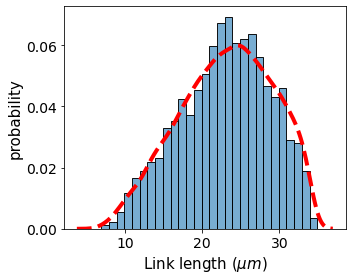

In [21]:
fig, ax = plt.subplots(figsize = (5,4))

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

sns.histplot(link_lengths_example, 
             stat = 'probability',
             palette='Set2',
             kde = False,
             cumulative=False,
             common_norm=False,
             binwidth = 1,
             alpha = 0.6)

sns.kdeplot(data=link_lengths_all, 
            c = 'r',
            ls = '--',
            lw = 4)

ax.set_ylabel('probability', fontsize = 15)
ax.set_xlabel('Link length ($\\mu m$)', fontsize = 15)
plt.tight_layout()

## 4. Looking at statistics over individual cells in the network

For the purpose of illustrating the possibilities of the network representation of the spheroids, we wanted to investigate the distribution of cell properties within the spheroid as a function of the layer number.

The supporting functions are a bit too tedious for an example file, but they essentially amount to calculating averages of certain properties such as link-lengths within the spheroid.

In [22]:
from collections import Counter
import networkx as nx

def get_neighbour_properties(G,
                             neighbour_descriptor = 'legend'):

    resultframe = pandas.DataFrame()
    i = 0
    
    neighbour_descriptors = nx.get_node_attributes(G, neighbour_descriptor)

    for node in G.nodes:
        
        resultframe.loc[i, 'label'] = node
        resultframe.loc[i, neighbour_descriptor] = neighbour_descriptors[node]
        resultframe.loc[i, 'degree'] = len([n for n in G.neighbors(node)])

        neighbour_props = [neighbour_descriptors[n] for n in G.neighbors(node)]
        neighbour_props_counter = Counter(neighbour_props)
                
        for key in neighbour_props_counter.keys():
            resultframe.loc[i, key] = neighbour_props_counter[key]
            
        i += 1

    return resultframe.fillna(0)


def get_network_properties(G, network_property):
        
    resultframe = pandas.DataFrame()
    i = 0
    
    network_property_dict = nx.get_node_attributes(G, network_property)
    
    for node in G.nodes:
        
        resultframe.loc[i, 'label'] = node
        resultframe.loc[i, network_property] = network_property_dict[node]
        i += 1

    return resultframe

def make_network_prop_frame(G,
                            network_property_list,
                            neighbour_descriptor = 'legend'
                            ):
    
    resultframe = get_neighbour_properties(G, 
                                           neighbour_descriptor = neighbour_descriptor)
    
    for network_property in network_property_list:
                
        resultframe = resultframe.merge(get_network_properties(G, network_property), on = 'label')
    
    return resultframe

def make_network_prop_graph_list(graph_list,
                                 network_property_list,
                                 neighbour_descriptor):
    
    prop_graph_list = pandas.DataFrame()
    i = 0
    
    for G in graph_list:
        
        single_spheroid_prop = make_network_prop_frame(G,
                            network_property_list,
                            neighbour_descriptor
                            )
        
        single_spheroid_prop['spheroid_no'] = i
        i += 1
                
        prop_graph_list = prop_graph_list.append(single_spheroid_prop)
        
    return prop_graph_list

network_property_list = ['neighbour_length_mean',
                         'cell_volume',
                         'layer']

def node_edge_properties(G):
    
    for node in G.nodes():
        
        length_list = []
        legend_dict = {}
        
        for neighbour in G[node]:
            
            length_list.append(G[node][neighbour]['length'])
            
        G.nodes[node]['neighbour_length_mean'] = np.mean(length_list)
        G.nodes[node]['neighbour_length'] = length_list
        G.nodes[node]['degree'] = len(G[node])
    return G

def get_node_edge_properties_graph_list(graph_list):
    
    new_graph_list = []
    
    for G in graph_list:
                
        G = node_edge_properties(G)
        
        new_graph_list.append(G)
        
    return new_graph_list

In [23]:
graph_list = get_node_edge_properties_graph_list(graph_list)

/Users/gustaveronteix/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/gustaveronteix/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [24]:
network_property_list = ['neighbour_length_mean',
                         'layer']
neighbour_descriptor = 'legend'

single_cell_properties_graph_list = make_network_prop_graph_list(graph_list,
                                 network_property_list,
                                 neighbour_descriptor)

In [25]:
single_cell_properties = single_cell_properties_graph_list[single_cell_properties_graph_list.spheroid_no == 0]

single_cell_properties['link_length'] = pxtomu*single_cell_properties.neighbour_length_mean
single_cell_properties_graph_list['link_length'] = pxtomu*single_cell_properties_graph_list.neighbour_length_mean

<ipython-input-25-caa1d5ac8b5f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_cell_properties['link_length'] = pxtomu*single_cell_properties.neighbour_length_mean


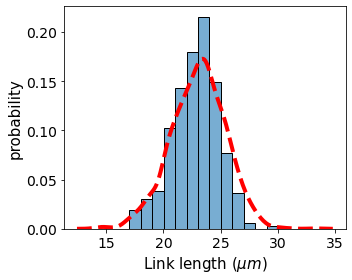

In [26]:
fig, ax = plt.subplots(figsize = (5,4))

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

g = sns.histplot(single_cell_properties, 
             x="link_length",
             stat = 'probability',
             palette='Set2',
             kde = False,
             cumulative=False,
             common_norm=False,
             binwidth = 1,
             alpha = 0.6)

sns.kdeplot(data=single_cell_properties_graph_list, 
            x="link_length",
            c = 'r',
            ls = '--',
            lw = 4)

ax.set_ylabel('probability', fontsize = 15)
ax.set_xlabel('Link length ($\\mu m$)', fontsize = 15)
plt.tight_layout()

#plt.savefig('plots/neighbour_length_distribution.pdf')

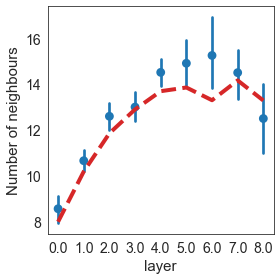

In [27]:
from matplotlib.ticker import MaxNLocator

sns.set_style('white')

fig, ax = plt.subplots(figsize = (4,4))

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

sns.pointplot(x = "layer",
             y = "degree",
             join = False,
             err_style="bars",
             ls ='',
             color= 'tab:blue',
             data = single_cell_properties)

sns.lineplot(x = "layer",
             y = "degree",
             markers = True,
             color = 'tab:red',
             palette='Set2',
             ci = None,
             ls = '--',
             lw = 4,
             data = single_cell_properties_graph_list )

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_ylabel('Number of neighbours', fontsize = 15)
ax.set_xlabel('layer', fontsize = 15)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()

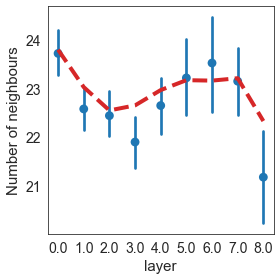

In [28]:
from matplotlib.ticker import MaxNLocator

sns.set_style('white')

fig, ax = plt.subplots(figsize = (4,4))

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

sns.pointplot(x = "layer",
             y = "link_length",
             join = False,
             err_style="bars",
             ls ='',
             color= 'tab:blue',
             data = single_cell_properties)

sns.lineplot(x = "layer",
             y = "link_length",
             markers = True,
             color = 'tab:red',
             palette='Set2',
             ci = None,
             ls = '--',
             lw = 4,
             data = single_cell_properties_graph_list )

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_ylabel('Number of neighbours', fontsize = 15)
ax.set_xlabel('layer', fontsize = 15)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()